<a href="https://colab.research.google.com/github/prashankkadam/Autoencoder/blob/master/VariationalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the required libraries**

In [0]:
import numpy as np 
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm

In [4]:
#loading the data
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# declaring the network parameters
batch_size, n_epoch = 100, 100
n_hidden, z_dim = 256, 2

(60000, 784) (10000, 784)


In [0]:
# Designing the encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

In [0]:
# Sampling function 
def sampling(args):
  mu, log_var = args
  eps = K.random_normal(shape=(batch_size, z_dim), mean=0, stddev=1.0)
  return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

In [0]:
# Designing the deocder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

In [12]:
# Calculating the loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# Building the model 
vae = Model(x, y)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

W0722 10:25:10.409663 139936220874624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0722 10:25:10.418573 139936220874624 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0722 10:25:10.442359 139936220874624 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          32896       dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            258         dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (D

In [13]:
# Training the model 
vae.fit(x_tr, 
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 11s 179us/step - loss: 189.1095 - val_loss: 165.8850
Epoch 2/100
60000/60000 [==============================] - 10s 165us/step - loss: 162.2314 - val_loss: 158.6998
Epoch 3/100
60000/60000 [==============================] - 10s 167us/step - loss: 157.1012 - val_loss: 155.0654
Epoch 4/100
60000/60000 [==============================] - 10s 168us/step - loss: 153.4729 - val_loss: 152.3912
Epoch 5/100
60000/60000 [==============================] - 10s 165us/step - loss: 150.8457 - val_loss: 149.6762
Epoch 6/100
60000/60000 [==============================] - 10s 162us/step - loss: 149.0057 - val_loss: 148.9862
Epoch 7/100
60000/60000 [==============================] - 10s 165us/step - loss: 147.3829 - val_loss: 146.7405
Epoch 8/100
60000/60000 [==============================] - 10s 165us/step - loss: 146.0587 - val_loss: 146.4472
Epoch 9/100
60000/60000 [=============================

In [14]:
# Build the ecoder
encoder = Model(x, mu)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


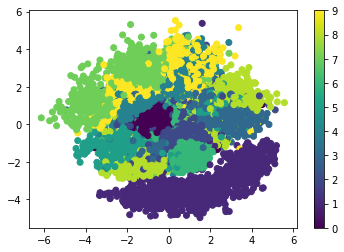

In [18]:
# Plotting the digits in latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure()
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [19]:
# Building the Decoder 
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_13 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_14 (Dense)             (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


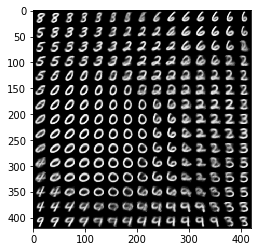

In [21]:
# Displaying the 2D mainfold
n =15
digit_size =28
figure = np.zeros((n * digit_size, n * digit_size))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size,
          j* digit_size: (j + 1) * digit_size] = digit
    
plt.figure()
plt.imshow(figure, cmap='Greys_r')
plt.show()